In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import os
import rasterio
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, random_split
from torchgeo.transforms import indices
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import tqdm
from PIL import Image
import dotenv
from datetime import datetime
import wandb
import random

import warnings
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning) # biomassters rasters are not georeferenced
warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

In [3]:
dotenv.load_dotenv()
os.chdir(os.environ['WORKING_DIR'])
import src.utils.transforms as tf
import src.utils.data_loader_v3 as dl
from config import CFG, CFG2
CFG = CFG()

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: g-broughton. Use `wandb login --relogin` to force relogin


True

In [5]:
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

if torch.backends.mps.is_available(): # Mac M1/M2
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

loader_device = torch.device('cpu')  # found that using cpu for data loading was faster than gpu (for my device)
print(f'training device: {device}')
print(f'loader_device: {loader_device}')

training device: cuda
loader_device: cpu


In [6]:
# Map of tensor channels *after* transforms, not accounting for bands dropped by the DropBands transform
# Useful for choosing which bands to keep 
band_map = CFG2.BAND_MAP
month_map = CFG2.MONTH_MAP

In [7]:
bands_to_keep = CFG.BANDS # via offline feature selection  

transforms = nn.Sequential(
    tf.ClampAGBM(vmin=0., vmax=500.),                # exclude AGBM outliers, 500 is good upper limit per AGBM histograms 
    indices.AppendNDVI(index_nir=6, index_red=2),    # NDVI, index 15
    indices.AppendNormalizedDifferenceIndex(index_a=11, index_b=12), # (VV-VH)/(VV+VH), index 16
    indices.AppendNDBI(index_swir=8, index_nir=6),   # Difference Built-up Index for development detection, index 17
    indices.AppendNDRE(index_nir=6, index_vre1=3),   # Red Edge Vegetation Index for canopy detection, index 18
    indices.AppendNDSI(index_green=1, index_swir=8), # Snow Index, index 19
    indices.AppendNDWI(index_green=1, index_nir=6),  # Difference Water Index for water detection, index 20 
    indices.AppendSWI(index_vre1=3, index_swir2=8),  # Standardized Water-Level Index for water detection, index 21
    tf.AppendRatioAB(index_a=11, index_b=12),        # VV/VH Ascending, index 22
    tf.AppendRatioAB(index_a=13, index_b=14),        # VV/VH Descending, index 23
    tf.DropBands(loader_device, bands_to_keep)       # DROPS ALL BUT SPECIFIED bands_to_keep
)

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_metrics = []
    
    print('Training')
    for ix, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = batch['image'].to(device)
        y = batch['label'].to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_metrics.append(np.round(np.sqrt(loss.item()), 5))

        example_cnt = ix * len(batch)
        if ((ix + 1) % 25) == 0:
            train_log(train_metrics[-1], example_cnt)
            
    return train_metrics


def valid_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    valid_loss = 0
    valid_metrics = {}
    
    print('Validation')
    with torch.no_grad():
        for batch in tqdm(dataloader, total=num_batches):
            X = batch['image'].to(device)
            y = batch['label'].to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            
    valid_loss /= num_batches
    valid_rmse = np.round(np.sqrt(valid_loss), 5)
    print(f"Validation Error: \n RMSE: {valid_rmse:>8f} \n")
    wandb.log({"test_accuracy": valid_rmse})
    return valid_rmse

def train_log(loss, example_ct):
    # Where the magic happens
    wandb.log({"loss": loss}, step=example_ct)
    print(f"Loss after {str(example_ct).zfill(5)} examples: {loss:.3f}")

In [9]:
def run_training(model, loss_module, optimizer, train_dataloader, val_dataloader, CFG):
    save_file = f'UNET_resnet50_20band_batch{CFG.BATCH_SIZE}_AGBMLinear_AllTrain_{CFG.EPOCHS}epoch_{datetime.now()}.pt'
    save_path = os.path.join(CFG.SAVED_MODELS, save_file)
    wandb.watch(model, loss_module, log="all", log_freq=10)
    min_valid_metric = np.inf
    train_metrics = []
    valid_metrics = []

    for ix in range(CFG.EPOCHS):
        print(f"\n-------------------------------\nEpoch {ix+1}")
        train_metrics_epoch = train_loop(train_dataloader, model, loss_module, optimizer)
        train_metrics.extend(train_metrics_epoch)
        
        valid_metrics_epoch = valid_loop(val_dataloader, model, loss_module)
        valid_metrics.append((len(train_metrics), valid_metrics_epoch))

        # check validation score, if improved then save model
        if min_valid_metric > valid_metrics_epoch:
            print(f'Validation RMSE Decreased({min_valid_metric:.6f}--->{valid_metrics_epoch:.6f}) \t Saving The Model')
            min_valid_metric = valid_metrics_epoch

            # Saving State Dict
            torch.save(model.state_dict(), save_path)
    print("Done!")
    train_metrics_zipped = list(zip(np.arange(0, len(train_metrics)), train_metrics))
    
    return {'training': train_metrics_zipped, 'validation': valid_metrics}

In [10]:
def make(transformations, config):

    dataset = dl.SentinelDataset(tile_file=config.TILE_FILE, 
                             dir_tiles=config.DIR_TILES, 
                             dir_target=config.DIR_TARGET,
                             max_chips=config.MAX_CHIPS,
                             transform=transforms,
                             device=loader_device,
                            )
    
    train_frac = config.TRAIN_FRAC
    upper = int(len(dataset)*train_frac)
    lower = len(dataset) - upper
    train_dataset, val_dataset = random_split(dataset, [upper, lower])
    print(f'N training samples: {len(train_dataset)}')
    
    train_dataloader = DataLoader(
                            train_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=True,
                            num_workers=config.WORKERS,
                            prefetch_factor=config.PREFETCH,
                            pin_memory=True
                            )
    
    val_dataloader = DataLoader(
                            val_dataset,
                            batch_size=config.BATCH_SIZE,
                            shuffle=False,
                            num_workers=config.WORKERS,
                            prefetch_factor=config.PREFETCH,
                            pin_memory=True
                            )

    in_channels = train_dataset[0]['image'].shape[0]
    print(f'# input channels: {in_channels}')

    model = smp.Unet(
        encoder_name="resnet50",
        encoder_weights='imagenet', # 'imagenet' weights don't seem to help so start clean 
        in_channels=in_channels,                 
        classes=1,                     
    ).to(device)
    #  model.load_state_dict(torch.load(f'trained_models/resnet50-sentinel2.pt'))

    loss_module = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)

    dataset_test = dl.SentinelDataset(
                                    tile_file=config.TILE_FILE_TEST, # specifies best months of test data 
                                    dir_tiles=config.DIR_TEST,       # test data dir
                                    dir_target=None,          # No AGBM targets for test data 
                                    max_chips=config.MAX_CHIPS,      
                                    transform=transforms,     # same transforms as training
                                    device=loader_device,
                                    )
    
    return model, train_dataloader, val_dataloader, loss_module, optimizer, dataset_test

In [11]:
def plot_training(metrics):
    df_train_metrics = pd.DataFrame(metrics['training'], columns=['step', 'score'])
    df_valid_metrics = pd.DataFrame(metrics['validation'], columns=['step', 'score'])
    plt.plot(df_train_metrics['step'], df_train_metrics['score'], label='Training')
    plt.plot(df_valid_metrics['step'], df_valid_metrics['score'], label='Validation')
    plt.ylim([0, 100])
    plt.legend()
    plt.show()

In [12]:
def save_agbm(agbm_pred, chipid, config):
    im = Image.fromarray(agbm_pred)
    save_path = os.path.join(config.DIR_PREDS, f'{chipid}_agbm.tif')
    im.save(save_path, format='TIFF', save_all=True)

def predict_agbm(inputs, model):
    pred = model.predict(inputs.unsqueeze(0))
    return pred.detach().squeeze().cpu().numpy()

def test(model, dataset_test, config):

    model.to(device)

    for ix, tile in tqdm(enumerate(dataset_test), total=len(dataset_test)-1):
        chipid = dataset_test.df_tile_list.iloc[ix]['chipid']
        inputs = tile['image'].to(device)
        agbm = predict_agbm(inputs, model)
        save_agbm(agbm, chipid, config)

In [13]:
def model_pipeline(transforms, hyperparameters):

    # tell wandb to get started
    with wandb.init(project="Finland Forests", tags=['baseline'], config=hyperparameters):
        # access all HPs through wandb.config, so logging matches execution!
        config = wandb.config

        # make the model, data, and optimization problem
        model, train_loader, val_loader, loss_module, optimizer, dataset_test = make(transforms, config)

        # and use them to train the model
        metrics = run_training(model, loss_module, optimizer, train_loader, val_loader, config)
        plot_training(metrics)
        
        # and test its final performance
        test(model, dataset_test, config)

    return model

In [14]:
model = model_pipeline(transforms, CFG)

N training samples: 6951
# input channels: 20

-------------------------------
Epoch 1
Training


 23%|██▎       | 25/109 [00:35<01:21,  1.03it/s]

Loss after 00048 examples: 60.989


 46%|████▌     | 50/109 [01:01<01:07,  1.14s/it]

Loss after 00098 examples: 62.462


 69%|██████▉   | 75/109 [01:25<00:32,  1.03it/s]

Loss after 00148 examples: 56.581


 92%|█████████▏| 100/109 [01:50<00:09,  1.09s/it]

Loss after 00198 examples: 55.833


100%|██████████| 109/109 [01:59<00:00,  1.09s/it]


Validation


100%|██████████| 28/28 [00:18<00:00,  1.54it/s]


Validation Error: 
 RMSE: 54.726860 

Validation RMSE Decreased(inf--->54.726860) 	 Saving The Model

-------------------------------
Epoch 2
Training


 23%|██▎       | 25/109 [00:32<01:25,  1.02s/it]

Loss after 00048 examples: 50.837


 46%|████▌     | 50/109 [00:57<00:55,  1.06it/s]

Loss after 00098 examples: 52.306


 69%|██████▉   | 75/109 [01:22<00:34,  1.01s/it]

Loss after 00148 examples: 60.723


 92%|█████████▏| 100/109 [01:47<00:08,  1.06it/s]

Loss after 00198 examples: 54.408


100%|██████████| 109/109 [01:56<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.63it/s]


Validation Error: 
 RMSE: 52.453690 

Validation RMSE Decreased(54.726860--->52.453690) 	 Saving The Model

-------------------------------
Epoch 3
Training


 23%|██▎       | 25/109 [00:30<01:21,  1.02it/s]

Loss after 00048 examples: 46.803


 46%|████▌     | 50/109 [00:56<00:57,  1.03it/s]

Loss after 00098 examples: 52.715


 69%|██████▉   | 75/109 [01:20<00:32,  1.04it/s]

Loss after 00148 examples: 48.803


 92%|█████████▏| 100/109 [01:45<00:08,  1.04it/s]

Loss after 00198 examples: 46.534


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.66it/s]


Validation Error: 
 RMSE: 51.025110 

Validation RMSE Decreased(52.453690--->51.025110) 	 Saving The Model

-------------------------------
Epoch 4
Training


 23%|██▎       | 25/109 [00:31<01:24,  1.00s/it]

Loss after 00048 examples: 49.748


 46%|████▌     | 50/109 [00:56<00:59,  1.01s/it]

Loss after 00098 examples: 51.638


 69%|██████▉   | 75/109 [01:21<00:33,  1.01it/s]

Loss after 00148 examples: 49.724


 92%|█████████▏| 100/109 [01:46<00:09,  1.01s/it]

Loss after 00198 examples: 50.164


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


Validation Error: 
 RMSE: 49.931130 

Validation RMSE Decreased(51.025110--->49.931130) 	 Saving The Model

-------------------------------
Epoch 5
Training


 23%|██▎       | 25/109 [00:32<01:29,  1.06s/it]

Loss after 00048 examples: 51.398


 46%|████▌     | 50/109 [00:57<00:56,  1.05it/s]

Loss after 00098 examples: 47.021


 69%|██████▉   | 75/109 [01:22<00:36,  1.07s/it]

Loss after 00148 examples: 50.410


 92%|█████████▏| 100/109 [01:47<00:08,  1.06it/s]

Loss after 00198 examples: 55.323


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.59it/s]


Validation Error: 
 RMSE: 48.773710 

Validation RMSE Decreased(49.931130--->48.773710) 	 Saving The Model

-------------------------------
Epoch 6
Training


 23%|██▎       | 25/109 [00:30<01:36,  1.15s/it]

Loss after 00048 examples: 48.465


 46%|████▌     | 50/109 [00:55<00:57,  1.03it/s]

Loss after 00098 examples: 47.687


 69%|██████▉   | 75/109 [01:20<00:39,  1.16s/it]

Loss after 00148 examples: 49.665


 92%|█████████▏| 100/109 [01:45<00:08,  1.04it/s]

Loss after 00198 examples: 47.243


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.65it/s]


Validation Error: 
 RMSE: 47.879110 

Validation RMSE Decreased(48.773710--->47.879110) 	 Saving The Model

-------------------------------
Epoch 7
Training


 23%|██▎       | 25/109 [00:30<01:19,  1.05it/s]

Loss after 00048 examples: 50.597


 46%|████▌     | 50/109 [00:56<00:59,  1.01s/it]

Loss after 00098 examples: 49.148


 69%|██████▉   | 75/109 [01:21<00:32,  1.05it/s]

Loss after 00148 examples: 47.950


 92%|█████████▏| 100/109 [01:46<00:08,  1.01it/s]

Loss after 00198 examples: 48.224


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.72it/s]


Validation Error: 
 RMSE: 46.963710 

Validation RMSE Decreased(47.879110--->46.963710) 	 Saving The Model

-------------------------------
Epoch 8
Training


 23%|██▎       | 25/109 [00:33<01:21,  1.03it/s]

Loss after 00048 examples: 52.479


 46%|████▌     | 50/109 [00:58<00:57,  1.02it/s]

Loss after 00098 examples: 48.989


 69%|██████▉   | 75/109 [01:24<00:33,  1.03it/s]

Loss after 00148 examples: 48.350


 92%|█████████▏| 100/109 [01:48<00:08,  1.04it/s]

Loss after 00198 examples: 46.156


100%|██████████| 109/109 [01:57<00:00,  1.08s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.58it/s]


Validation Error: 
 RMSE: 46.691040 

Validation RMSE Decreased(46.963710--->46.691040) 	 Saving The Model

-------------------------------
Epoch 9
Training


 23%|██▎       | 25/109 [00:30<01:27,  1.04s/it]

Loss after 00048 examples: 47.869


 46%|████▌     | 50/109 [00:55<00:58,  1.01it/s]

Loss after 00098 examples: 47.615


 69%|██████▉   | 75/109 [01:21<00:35,  1.04s/it]

Loss after 00148 examples: 52.736


 92%|█████████▏| 100/109 [01:45<00:08,  1.02it/s]

Loss after 00198 examples: 45.856


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.65it/s]


Validation Error: 
 RMSE: 46.179680 

Validation RMSE Decreased(46.691040--->46.179680) 	 Saving The Model

-------------------------------
Epoch 10
Training


 23%|██▎       | 25/109 [00:29<01:20,  1.05it/s]

Loss after 00048 examples: 45.116


 46%|████▌     | 50/109 [00:55<01:02,  1.06s/it]

Loss after 00098 examples: 44.638


 69%|██████▉   | 75/109 [01:20<00:32,  1.05it/s]

Loss after 00148 examples: 43.513


 92%|█████████▏| 100/109 [01:45<00:09,  1.02s/it]

Loss after 00198 examples: 44.676


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.75it/s]


Validation Error: 
 RMSE: 45.578360 

Validation RMSE Decreased(46.179680--->45.578360) 	 Saving The Model

-------------------------------
Epoch 11
Training


 23%|██▎       | 25/109 [00:30<01:21,  1.03it/s]

Loss after 00048 examples: 46.292


 46%|████▌     | 50/109 [00:56<01:07,  1.15s/it]

Loss after 00098 examples: 45.965


 69%|██████▉   | 75/109 [01:20<00:33,  1.03it/s]

Loss after 00148 examples: 45.746


 92%|█████████▏| 100/109 [01:46<00:09,  1.10s/it]

Loss after 00198 examples: 42.672


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:18<00:00,  1.55it/s]


Validation Error: 
 RMSE: 45.512280 

Validation RMSE Decreased(45.578360--->45.512280) 	 Saving The Model

-------------------------------
Epoch 12
Training


 23%|██▎       | 25/109 [00:31<01:25,  1.02s/it]

Loss after 00048 examples: 43.443


 46%|████▌     | 50/109 [00:56<00:56,  1.05it/s]

Loss after 00098 examples: 45.844


 69%|██████▉   | 75/109 [01:22<00:34,  1.02s/it]

Loss after 00148 examples: 46.013


 92%|█████████▏| 100/109 [01:46<00:08,  1.06it/s]

Loss after 00198 examples: 45.360


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.57it/s]


Validation Error: 
 RMSE: 44.756400 

Validation RMSE Decreased(45.512280--->44.756400) 	 Saving The Model

-------------------------------
Epoch 13
Training


 23%|██▎       | 25/109 [00:30<01:22,  1.02it/s]

Loss after 00048 examples: 41.492


 46%|████▌     | 50/109 [00:56<00:57,  1.03it/s]

Loss after 00098 examples: 46.303


 69%|██████▉   | 75/109 [01:21<00:33,  1.02it/s]

Loss after 00148 examples: 44.519


 92%|█████████▏| 100/109 [01:46<00:08,  1.04it/s]

Loss after 00198 examples: 50.252


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.63it/s]

Validation Error: 
 RMSE: 45.207360 


-------------------------------
Epoch 14
Training



 23%|██▎       | 25/109 [00:30<01:24,  1.01s/it]

Loss after 00048 examples: 46.141


 46%|████▌     | 50/109 [00:56<01:00,  1.03s/it]

Loss after 00098 examples: 45.584


 69%|██████▉   | 75/109 [01:21<00:33,  1.00it/s]

Loss after 00148 examples: 45.771


 92%|█████████▏| 100/109 [01:46<00:08,  1.00it/s]

Loss after 00198 examples: 46.099


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:15<00:00,  1.76it/s]

Validation Error: 
 RMSE: 44.802060 


-------------------------------
Epoch 15
Training



 23%|██▎       | 25/109 [00:32<01:29,  1.06s/it]

Loss after 00048 examples: 44.066


 46%|████▌     | 50/109 [00:57<00:56,  1.05it/s]

Loss after 00098 examples: 44.219


 69%|██████▉   | 75/109 [01:23<00:35,  1.05s/it]

Loss after 00148 examples: 47.351


 92%|█████████▏| 100/109 [01:47<00:08,  1.05it/s]

Loss after 00198 examples: 41.547


100%|██████████| 109/109 [01:56<00:00,  1.07s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.60it/s]


Validation Error: 
 RMSE: 44.239280 

Validation RMSE Decreased(44.756400--->44.239280) 	 Saving The Model

-------------------------------
Epoch 16
Training


 23%|██▎       | 25/109 [00:31<01:36,  1.15s/it]

Loss after 00048 examples: 43.143


 46%|████▌     | 50/109 [00:56<00:57,  1.03it/s]

Loss after 00098 examples: 45.118


 69%|██████▉   | 75/109 [01:21<00:38,  1.14s/it]

Loss after 00148 examples: 41.541


 92%|█████████▏| 100/109 [01:46<00:08,  1.04it/s]

Loss after 00198 examples: 44.407


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.64it/s]


Validation Error: 
 RMSE: 43.973930 

Validation RMSE Decreased(44.239280--->43.973930) 	 Saving The Model

-------------------------------
Epoch 17
Training


 23%|██▎       | 25/109 [00:30<01:19,  1.05it/s]

Loss after 00048 examples: 46.343


 46%|████▌     | 50/109 [00:55<01:01,  1.03s/it]

Loss after 00098 examples: 42.457


 69%|██████▉   | 75/109 [01:20<00:32,  1.06it/s]

Loss after 00148 examples: 44.516


 92%|█████████▏| 100/109 [01:45<00:08,  1.00it/s]

Loss after 00198 examples: 42.895


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.73it/s]


Validation Error: 
 RMSE: 43.615160 

Validation RMSE Decreased(43.973930--->43.615160) 	 Saving The Model

-------------------------------
Epoch 18
Training


 23%|██▎       | 25/109 [00:33<01:21,  1.03it/s]

Loss after 00048 examples: 41.863


 46%|████▌     | 50/109 [00:58<00:57,  1.03it/s]

Loss after 00098 examples: 45.003


 69%|██████▉   | 75/109 [01:23<00:33,  1.03it/s]

Loss after 00148 examples: 45.036


 92%|█████████▏| 100/109 [01:48<00:08,  1.04it/s]

Loss after 00198 examples: 40.930


100%|██████████| 109/109 [01:57<00:00,  1.08s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.56it/s]

Validation Error: 
 RMSE: 43.682100 


-------------------------------
Epoch 19
Training



 23%|██▎       | 25/109 [00:32<01:27,  1.05s/it]

Loss after 00048 examples: 42.611


 46%|████▌     | 50/109 [00:57<00:59,  1.01s/it]

Loss after 00098 examples: 41.837


 69%|██████▉   | 75/109 [01:22<00:35,  1.04s/it]

Loss after 00148 examples: 46.018


 92%|█████████▏| 100/109 [01:47<00:08,  1.02it/s]

Loss after 00198 examples: 44.021


100%|██████████| 109/109 [01:56<00:00,  1.07s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.64it/s]


Validation Error: 
 RMSE: 43.332610 

Validation RMSE Decreased(43.615160--->43.332610) 	 Saving The Model

-------------------------------
Epoch 20
Training


 23%|██▎       | 25/109 [00:31<01:20,  1.05it/s]

Loss after 00048 examples: 42.690


 46%|████▌     | 50/109 [00:57<01:01,  1.04s/it]

Loss after 00098 examples: 45.829


 69%|██████▉   | 75/109 [01:22<00:32,  1.04it/s]

Loss after 00148 examples: 45.128


 92%|█████████▏| 100/109 [01:47<00:09,  1.02s/it]

Loss after 00198 examples: 39.228


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.68it/s]

Validation Error: 
 RMSE: 43.399760 


-------------------------------
Epoch 21
Training



 23%|██▎       | 25/109 [00:29<01:21,  1.03it/s]

Loss after 00048 examples: 44.263


 46%|████▌     | 50/109 [00:55<01:08,  1.15s/it]

Loss after 00098 examples: 43.239


 69%|██████▉   | 75/109 [01:19<00:32,  1.04it/s]

Loss after 00148 examples: 43.706


 92%|█████████▏| 100/109 [01:44<00:09,  1.09s/it]

Loss after 00198 examples: 42.247


100%|██████████| 109/109 [01:53<00:00,  1.04s/it]


Validation


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]

Validation Error: 
 RMSE: 43.502260 


-------------------------------
Epoch 22
Training



 23%|██▎       | 25/109 [00:32<01:25,  1.02s/it]

Loss after 00048 examples: 45.537


 46%|████▌     | 50/109 [00:56<00:56,  1.05it/s]

Loss after 00098 examples: 43.375


 69%|██████▉   | 75/109 [01:22<00:34,  1.02s/it]

Loss after 00148 examples: 39.872


 92%|█████████▏| 100/109 [01:46<00:08,  1.06it/s]

Loss after 00198 examples: 43.101


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.64it/s]

Validation Error: 
 RMSE: 43.439600 


-------------------------------
Epoch 23
Training



 23%|██▎       | 25/109 [00:30<01:22,  1.02it/s]

Loss after 00048 examples: 43.356


 46%|████▌     | 50/109 [00:56<00:57,  1.03it/s]

Loss after 00098 examples: 42.374


 69%|██████▉   | 75/109 [01:21<00:33,  1.01it/s]

Loss after 00148 examples: 42.855


 92%|█████████▏| 100/109 [01:46<00:08,  1.04it/s]

Loss after 00198 examples: 41.249


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.70it/s]


Validation Error: 
 RMSE: 42.873070 

Validation RMSE Decreased(43.332610--->42.873070) 	 Saving The Model

-------------------------------
Epoch 24
Training


 23%|██▎       | 25/109 [00:30<01:24,  1.01s/it]

Loss after 00048 examples: 43.637


 46%|████▌     | 50/109 [00:56<01:01,  1.04s/it]

Loss after 00098 examples: 41.480


 69%|██████▉   | 75/109 [01:21<00:34,  1.00s/it]

Loss after 00148 examples: 41.435


 92%|█████████▏| 100/109 [01:46<00:09,  1.01s/it]

Loss after 00198 examples: 39.791


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:15<00:00,  1.82it/s]

Validation Error: 
 RMSE: 43.354350 


-------------------------------
Epoch 25
Training



 23%|██▎       | 25/109 [00:33<01:29,  1.07s/it]

Loss after 00048 examples: 41.634


 46%|████▌     | 50/109 [00:57<00:56,  1.05it/s]

Loss after 00098 examples: 41.152


 69%|██████▉   | 75/109 [01:23<00:35,  1.03s/it]

Loss after 00148 examples: 43.495


 92%|█████████▏| 100/109 [01:47<00:08,  1.05it/s]

Loss after 00198 examples: 43.668


100%|██████████| 109/109 [01:56<00:00,  1.07s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.60it/s]

Validation Error: 
 RMSE: 43.055670 


-------------------------------
Epoch 26
Training



 23%|██▎       | 25/109 [00:31<01:37,  1.16s/it]

Loss after 00048 examples: 43.324


 46%|████▌     | 50/109 [00:56<00:57,  1.02it/s]

Loss after 00098 examples: 39.633


 69%|██████▉   | 75/109 [01:21<00:39,  1.15s/it]

Loss after 00148 examples: 42.180


 92%|█████████▏| 100/109 [01:46<00:08,  1.04it/s]

Loss after 00198 examples: 40.950


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.70it/s]

Validation Error: 
 RMSE: 42.984710 


-------------------------------
Epoch 27
Training



 23%|██▎       | 25/109 [00:31<01:19,  1.05it/s]

Loss after 00048 examples: 40.088


 46%|████▌     | 50/109 [00:57<01:00,  1.02s/it]

Loss after 00098 examples: 42.207


 69%|██████▉   | 75/109 [01:21<00:32,  1.05it/s]

Loss after 00148 examples: 44.243


 92%|█████████▏| 100/109 [01:46<00:08,  1.01it/s]

Loss after 00198 examples: 41.827


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:15<00:00,  1.79it/s]


Validation Error: 
 RMSE: 42.810760 

Validation RMSE Decreased(42.873070--->42.810760) 	 Saving The Model

-------------------------------
Epoch 28
Training


 23%|██▎       | 25/109 [00:33<01:23,  1.01it/s]

Loss after 00048 examples: 38.685


 46%|████▌     | 50/109 [00:58<00:58,  1.02it/s]

Loss after 00098 examples: 45.189


 69%|██████▉   | 75/109 [01:23<00:32,  1.03it/s]

Loss after 00148 examples: 40.962


 92%|█████████▏| 100/109 [01:48<00:08,  1.04it/s]

Loss after 00198 examples: 40.226


100%|██████████| 109/109 [01:57<00:00,  1.08s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.56it/s]

Validation Error: 
 RMSE: 42.957230 


-------------------------------
Epoch 29
Training



 23%|██▎       | 25/109 [00:31<01:27,  1.04s/it]

Loss after 00048 examples: 41.580


 46%|████▌     | 50/109 [00:56<00:58,  1.01it/s]

Loss after 00098 examples: 42.992


 69%|██████▉   | 75/109 [01:21<00:35,  1.03s/it]

Loss after 00148 examples: 41.899


 92%|█████████▏| 100/109 [01:46<00:08,  1.02it/s]

Loss after 00198 examples: 44.926


100%|██████████| 109/109 [01:55<00:00,  1.06s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.66it/s]

Validation Error: 
 RMSE: 43.031400 


-------------------------------
Epoch 30
Training



 23%|██▎       | 25/109 [00:30<01:20,  1.05it/s]

Loss after 00048 examples: 41.039


 46%|████▌     | 50/109 [00:55<01:02,  1.07s/it]

Loss after 00098 examples: 42.922


 69%|██████▉   | 75/109 [01:20<00:32,  1.04it/s]

Loss after 00148 examples: 40.040


 92%|█████████▏| 100/109 [01:45<00:09,  1.02s/it]

Loss after 00198 examples: 43.064


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.63it/s]


Validation Error: 
 RMSE: 42.651270 

Validation RMSE Decreased(42.810760--->42.651270) 	 Saving The Model

-------------------------------
Epoch 31
Training


 23%|██▎       | 25/109 [00:30<01:21,  1.03it/s]

Loss after 00048 examples: 38.672


 46%|████▌     | 50/109 [00:55<01:07,  1.14s/it]

Loss after 00098 examples: 38.902


 69%|██████▉   | 75/109 [01:20<00:32,  1.03it/s]

Loss after 00148 examples: 41.864


 92%|█████████▏| 100/109 [01:45<00:09,  1.10s/it]

Loss after 00198 examples: 41.371


100%|██████████| 109/109 [01:53<00:00,  1.04s/it]


Validation


100%|██████████| 28/28 [00:18<00:00,  1.52it/s]

Validation Error: 
 RMSE: 43.131600 


-------------------------------
Epoch 32
Training



 23%|██▎       | 25/109 [00:31<01:25,  1.01s/it]

Loss after 00048 examples: 42.903


 46%|████▌     | 50/109 [00:56<00:55,  1.05it/s]

Loss after 00098 examples: 41.340


 69%|██████▉   | 75/109 [01:21<00:34,  1.02s/it]

Loss after 00148 examples: 41.378


 92%|█████████▏| 100/109 [01:46<00:08,  1.06it/s]

Loss after 00198 examples: 42.787


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:17<00:00,  1.63it/s]

Validation Error: 
 RMSE: 43.004790 


-------------------------------
Epoch 33
Training



 23%|██▎       | 25/109 [00:30<01:21,  1.02it/s]

Loss after 00048 examples: 37.071


 46%|████▌     | 50/109 [00:55<00:57,  1.03it/s]

Loss after 00098 examples: 39.297


 69%|██████▉   | 75/109 [01:20<00:33,  1.02it/s]

Loss after 00148 examples: 40.625


 92%|█████████▏| 100/109 [01:45<00:08,  1.04it/s]

Loss after 00198 examples: 40.871


100%|██████████| 109/109 [01:54<00:00,  1.05s/it]


Validation


100%|██████████| 28/28 [00:16<00:00,  1.68it/s]

Validation Error: 
 RMSE: 42.886280 


-------------------------------
Epoch 34
Training



 23%|██▎       | 25/109 [00:30<01:24,  1.00s/it]

Loss after 00048 examples: 41.616


 46%|████▌     | 50/109 [00:55<01:00,  1.02s/it]

Loss after 00098 examples: 42.049


 62%|██████▏   | 68/109 [01:12<00:39,  1.05it/s]

In [17]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights=None, # 'imagenet' weights don't seem to help so start clean 
    in_channels=20,                 
    classes=1,                     
).to(device)
model.load_state_dict(torch.load(f'{CFG.SAVED_MODELS}/UNET_resnet50_20band_batch56_AGBMLinear_AllTrain_5epoch_2023-01-22 15:44:39.035979.pt'))

<All keys matched successfully>

In [33]:
dataset_test = dl.SentinelDataset(
                                tile_file=CFG.TILE_FILE_TEST, # specifies best months of test data 
                                dir_tiles=CFG.DIR_TEST,       # test data dir
                                dir_target=None,          # No AGBM targets for test data 
                                max_chips=CFG.MAX_CHIPS,      
                                transform=transforms,     # same transforms as training
                                device=loader_device,
                                )
test(model, dataset_test, CFG)

100%|██████████| 2773/2773 [02:34<00:00, 17.95it/s]


KeyError: 2773

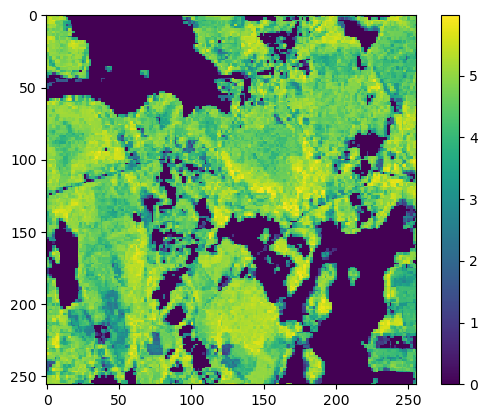

In [29]:
tile_idx = 1000  # arbitrary tile 

sample = dataset[tile_idx]
agbm = sample['label'].squeeze().detach().cpu().numpy()
agbm_log1p = np.log1p(agbm)  # visual comparison is easier with log transform; log1p handles small and 0 values
vmin = agbm_log1p.min()
vmax = agbm_log1p.max()

plt.imshow(agbm_log1p, vmin=vmin, vmax=vmax, interpolation='none')
plt.colorbar()
plt.show()

In [39]:
# Show predictions
model.to(device)

tile = sample['image'].to(device)
pred = predict_agbm(tile, model)

plt.imshow(np.log1p(pred), vmin=vmin, vmax=vmax, interpolation='none')
plt.colorbar()
plt.show()

NameError: name 'sample' is not defined

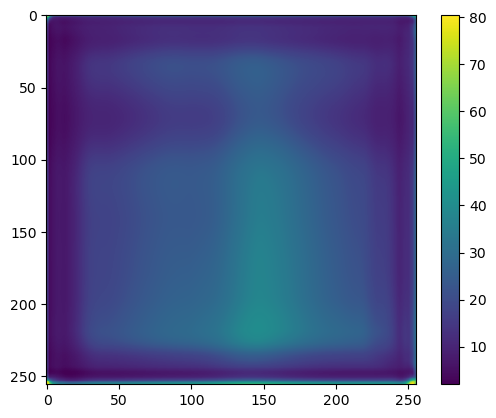

In [39]:
tile_idx = 1000 # arbitrary tile 

chipid = dataset_test.df_tile_list.iloc[tile_idx]['chipid']
inputs = dataset_test[tile_idx]['image'].to(device)
agbm = predict_agbm(inputs, model)

plt.imshow(agbm)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(test_pred)
plt.colorbar()
plt.show()